In [1]:
execfile('desolvationGrid.py')

self.calc_receptor_SAS_points()
self.calc_receptor_MS()

SAS_r = self.kwargs['ligand_atom_radius'] + self.kwargs['probe_radius']
SAS_sphere_pts = SAS_r*self.unit_sphere_pts

Reading header from /Users/dminh/clusters/CCB/AstexDiv_xtal/3-grids/1tow/header_coarse.dx
*** Files and parameters ***
Input AMBER prmtop      :	/Users/dminh/clusters/CCB/AstexDiv_xtal/1-build/1tow/receptor.prmtop
Input AMBER inpcrd      :	/Users/dminh/clusters/CCB/AstexDiv_xtal/3-grids/1tow/receptor.trans.inpcrd
Input grid header file  :	/Users/dminh/clusters/CCB/AstexDiv_xtal/3-grids/1tow/header_coarse.dx
Output grid             :	desolv.dx
Grid spacing            :	[ 0.5  0.5  0.5]
Grid counts             :	[73 73 73]

Finding receptor SAS points
 in 7.31 s
Determining the number of SAS points marking each grid point
 in 4.01 s


In [2]:
%load_ext Cython

In [3]:
%%cython --annotate

import cython
import numpy as np
cimport numpy as np

ctypedef np.int_t int_t
ctypedef np.float_t float_t

# This is the original python code for enumerate_SAS_points
# def enumerate_SAS_points(to_surround, to_avoid, \
#     unit_sphere_pts, SAS_r, LJ_r2):
#   SAS_points = []
#   for atom_i in range(len(SAS_r)):
#     receptor_SAS_points_n = [point for point in \
#       to_surround[atom_i,:] + unit_sphere_pts*SAS_r[atom_i] \
#       if not (np.sum(np.square(point-to_avoid),1)<LJ_r2).any()]
#     SAS_points.extend(receptor_SAS_points_n)
#   return SAS_points

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef enumerate_SAS_points(float_t[:,:] to_surround, float_t[:,:] to_avoid, \
    float_t[:,:] unit_sphere_pts, float_t[:] SAS_r, float_t[:] LJ_r2):
  cdef int_t clash
  cdef int_t natoms_to_surround, natoms_to_avoid, nsphere_points
  cdef int_t atom_i, atom_j, sphere_i, d
  cdef float_t atom_x, atom_y, atom_z
  cdef float_t point_x, point_y, point_z
  cdef float_t dx, dy, dz
  cdef float_t SAS_radius

  natoms_to_surround = len(SAS_r)
  natoms_to_avoid = len(LJ_r2)
  nsphere_points = len(unit_sphere_pts)

  SAS_points = []
  atom_i = 0
  while atom_i < natoms_to_surround:
    atom_x = to_surround[atom_i,0]
    atom_y = to_surround[atom_i,1]
    atom_z = to_surround[atom_i,2]
    SAS_radius = SAS_r[atom_i]
    sphere_i = 0
    while sphere_i < nsphere_points:
      # Propose a point at the SAS of the atom
      point_x = unit_sphere_pts[sphere_i,0]*SAS_radius + atom_x
      point_y = unit_sphere_pts[sphere_i,1]*SAS_radius + atom_y
      point_z = unit_sphere_pts[sphere_i,2]*SAS_radius + atom_z
      clash = 0
      atom_j = 0
      while atom_j < natoms_to_avoid:
        dx = to_avoid[atom_j,0] - point_x
        dy = to_avoid[atom_j,1] - point_y
        dz = to_avoid[atom_j,2] - point_z
        if (dx*dx + dy*dy + dz*dz) < LJ_r2[atom_j]:
          clash = 1
          atom_j = natoms_to_avoid
        else:
          atom_j += 1
      if clash==0:
        SAS_points.append((point_x,point_y,point_z))
      sphere_i += 1
    atom_i += 1
  return np.array(SAS_points)

# This is the original python code for set_inside_sphere_to
# def set_inside_sphere_to(grid, spacing, counts, point, r, val):
#   lower_lim = [max(int(np.floor((point[d]-r)/spacing[d])),0) \
#     for d in range(3)]
#   upper_lim = [min(int(np.ceil((point[d]+r)/spacing[d])),counts[d]) \
#     for d in range(3)]
#   r2 = r*r
#   for i in range(lower_lim[0],upper_lim[0]):
#     dx  = point_x-i*spacing[0]
#     dx2 = dx*dx
#     for j in range(lower_lim[1],upper_lim[1]):
#       dy  = point_y-j*spacing[1]
#       dy2 = dy*dy
#       for k in range(lower_lim[2],upper_lim[2]):
#         dz  = point_z-k*spacing[2]
#         dz2 = dz*dz
#         if (dx2 + dy2 + dz2) < r2:
#           grid[i,j,k]=val

# The following three functions are the same except that
# one sets the grid value,
# one increments the grid value, and
# one decrements the grid value
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef set_inside_sphere_to(\
    int_t[:,:,:] grid, \
    float_t[:] spacing, \
    int_t[:] counts, \
    float_t point_x, \
    float_t point_y, \
    float_t point_z, \
    float_t r, \
    int_t val):

  cdef int_t i, j, k
  cdef int_t i_min, i_max, j_min, j_max, k_min, k_max
  cdef float_t dx, dy, dz, dx2, dy2, dz2, dx2dy2, r2
  
  i_min = max(int((point_x-r)/spacing[0]),0)
  i_max = min(int((point_x+r)/spacing[0])+1,counts[0])
  j_min = max(int((point_y-r)/spacing[1]),0)
  j_max = min(int((point_y+r)/spacing[1])+1,counts[1])
  k_min = max(int((point_z-r)/spacing[2]),0)
  k_max = min(int((point_z+r)/spacing[2])+1,counts[2])

  r2 = r*r
  i = i_min
  while i<i_max:
    dx  = point_x-i*spacing[0]
    dx2 = dx*dx
    j = j_min
    while j<j_max:
      dy  = point_y-j*spacing[1]
      dy2 = dy*dy
      dx2dy2 = dx2 + dy2
      if dx2dy2 < r2:
        k = k_min
        while k<k_max:
          dz  = point_z-k*spacing[2]
          dz2 = dz*dz
          if (dx2dy2 + dz2) < r2:
            grid[i,j,k]=val
          k += 1
      j += 1
    i += 1

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef increment_inside_sphere(\
    int_t[:,:,:] grid, \
    float_t[:] spacing, \
    int_t[:] counts, \
    float_t point_x, \
    float_t point_y, \
    float_t point_z, \
    float_t r):

  cdef int_t i, j, k
  cdef int_t i_min, i_max, j_min, j_max, k_min, k_max
  cdef float_t dx, dy, dz, dx2, dy2, dz2, dx2dy2, r2
  
  i_min = max(int((point_x-r)/spacing[0]),0)
  i_max = min(int((point_x+r)/spacing[0])+1,counts[0])
  j_min = max(int((point_y-r)/spacing[1]),0)
  j_max = min(int((point_y+r)/spacing[1])+1,counts[1])
  k_min = max(int((point_z-r)/spacing[2]),0)
  k_max = min(int((point_z+r)/spacing[2])+1,counts[2])

  r2 = r*r
  i = i_min
  while i<i_max:
    dx  = point_x-i*spacing[0]
    dx2 = dx*dx
    j = j_min
    while j<j_max:
      dy  = point_y-j*spacing[1]
      dy2 = dy*dy
      dx2dy2 = dx2 + dy2
      if dx2dy2 < r2:
        k = k_min
        while k<k_max:
          dz  = point_z-k*spacing[2]
          dz2 = dz*dz
          if (dx2dy2 + dz2) < r2:
            grid[i,j,k]+=1
          k += 1
      j += 1
    i += 1

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef decrement_inside_sphere(\
    int_t[:,:,:] grid, \
    float_t[:] spacing, \
    int_t[:] counts, \
    float_t point_x, \
    float_t point_y, \
    float_t point_z, \
    float_t r):

  cdef int_t i, j, k
  cdef int_t i_min, i_max, j_min, j_max, k_min, k_max
  cdef float_t dx, dy, dz, dx2, dy2, dz2, dx2dy2, r2
  
  i_min = max(int((point_x-r)/spacing[0]),0)
  i_max = min(int((point_x+r)/spacing[0])+1,counts[0])
  j_min = max(int((point_y-r)/spacing[1]),0)
  j_max = min(int((point_y+r)/spacing[1])+1,counts[1])
  k_min = max(int((point_z-r)/spacing[2]),0)
  k_max = min(int((point_z+r)/spacing[2])+1,counts[2])

  r2 = r*r
  i = i_min
  while i<i_max:
    dx  = point_x-i*spacing[0]
    dx2 = dx*dx
    j = j_min
    while j<j_max:
      dy  = point_y-j*spacing[1]
      dy2 = dy*dy
      dx2dy2 = dx2 + dy2
      if dx2dy2 < r2:
        k = k_min
        while k<k_max:
          dz  = point_z-k*spacing[2]
          dz2 = dz*dz
          if (dx2dy2 + dz2) < r2:
            grid[i,j,k]-=1
          k += 1
      j += 1
    i += 1

# Performs numerical integrals of r**(-4) over the grid points
# between r_min and r_max, either
# over the low dielectric region or over all points
# Returns the ratio of the integrals
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef fraction_r4inv_low_dielectric(\
    int_t[:,:,:] grid, \
    float_t[:] spacing, \
    int_t[:] counts, \
    float_t point_x, \
    float_t point_y, \
    float_t point_z, \
    float_t r_min, \
    float_t r_max):
  cdef int_t i, j, k
  cdef int_t i_min, i_max, j_min, j_max, k_min, k_max
  cdef float_t I_low_dielectric, I_total
  cdef float_t dx, dy, dz, dx2, dy2, dz2, dx2dy2
  cdef float_t r2, r_min2, r_max2, r4inv
    
  I_low_dielectric = 0.
  I_total = 0.

  i_min = max(int((point_x-r_max)/spacing[0]),0)
  i_max = min(int((point_x+r_max)/spacing[0])+1,counts[0])
  j_min = max(int((point_y-r_max)/spacing[1]),0)
  j_max = min(int((point_y+r_max)/spacing[1])+1,counts[1])
  k_min = max(int((point_z-r_max)/spacing[2]),0)
  k_max = min(int((point_z+r_max)/spacing[2])+1,counts[2])

  r_min2 = r_min*r_min
  r_max2 = r_max*r_max
  i = i_min
  while i<i_max:
    dx  = point_x-i*spacing[0]
    dx2 = dx*dx
    j = j_min
    while j<j_max:
      dy  = point_y-j*spacing[1]
      dy2 = dy*dy
      dx2dy2 = dx2 + dy2
      if dx2dy2 < r_max2:
        k = k_min
        while k<k_max:
          dz  = point_z-k*spacing[2]
          dz2 = dz*dz
          r2 = dx2dy2 + dz2
          if (r2 < r_max2) and (r2 > r_min2):
            r4inv = 1/(r2*r2)
            if grid[i,j,k]<1:
              I_low_dielectric += r4inv
            I_total += r4inv
          k += 1
      j += 1
    i += 1
  return I_low_dielectric/I_total

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef calc_desolvationGrid(int_t[:,:,:] receptor_MS_grid, \
    float_t[:] spacing, int_t[:] counts, \
    float_t[:,:] receptor_SAS_points, \
    float_t[:,:] receptor_coordinates, \
    float_t[:,:] SAS_sphere_pts, \
    float_t[:] LJ_r2, \
    float_t LJ_r_max, \
    float_t ligand_atom_radius, \
    float_t probe_radius, \
    float_t integration_cutoff):
  cdef size_t i, j, k, n
  cdef int_t nreceptor_SAS_points
  cdef float_t SAS_x_min, SAS_x_max, SAS_y_min, SAS_y_max, SAS_z_min, SAS_z_max
  cdef float_t clash_filter_r
  cdef float_t rec_x_min, rec_x_max, rec_y_min, rec_y_max, rec_z_min, rec_z_max
  cdef float_t ligand_atom_radius2
  cdef float_t grid_point_x, grid_point_y, grid_point_z
  cdef np.ndarray[float_t, ndim=3] desolvationGrid

  # To use for new SAS points
  cdef size_t atom_j, sphere_i, d
  cdef int_t clash
  cdef int_t nreceptor_atoms, nsphere_points, n_newly_inaccessible_SAS_points
  cdef float_t SAS_point_x, SAS_point_y, SAS_point_z
  cdef float_t dx, dy, dz  
  cdef np.ndarray[int_t, ndim=3] grid_c

  nreceptor_SAS_points = receptor_SAS_points.shape[0]
  nreceptor_atoms = len(LJ_r2)
  nsphere_points = len(SAS_sphere_pts)

  ligand_atom_radius2 = ligand_atom_radius*ligand_atom_radius
  # Receptor atoms that clash with the ligand atom SAS will be within
  # the SAS and maximum LJ radius
  clash_filter_r = ligand_atom_radius + probe_radius + LJ_r_max
    
  desolvationGrid = np.zeros(shape=tuple(counts), dtype=np.float)
  
  for i in xrange(counts[0]):
    grid_point_x = i*spacing[0]
    # These are for filtering receptor_SAS_points and receptor_coordinates
    SAS_x_min = grid_point_x - ligand_atom_radius
    SAS_x_max = grid_point_x + ligand_atom_radius
    receptor_SAS_points_i = [n for n in xrange(nreceptor_SAS_points) \
      if (receptor_SAS_points[n,0]>SAS_x_min) and \
         (receptor_SAS_points[n,0]<SAS_x_max)]
    rec_x_min = grid_point_x - clash_filter_r
    rec_x_max = grid_point_x + clash_filter_r
    receptor_coordinates_i = [n for n in xrange(nreceptor_atoms) \
      if (receptor_coordinates[n,0]>rec_x_min) and \
         (receptor_coordinates[n,0]<rec_x_max)]
    for j in xrange(counts[1]):
      grid_point_y = j*spacing[1]
      # These are for filtering receptor_SAS_points and receptor_coordinates
      SAS_y_min = grid_point_y - ligand_atom_radius
      SAS_y_max = grid_point_y + ligand_atom_radius
      receptor_SAS_points_ij = [n for n in receptor_SAS_points_i \
        if (receptor_SAS_points[n,1]>SAS_y_min) and \
           (receptor_SAS_points[n,1]<SAS_y_max)]
      rec_y_min = grid_point_y - clash_filter_r
      rec_y_max = grid_point_y + clash_filter_r
      receptor_coordinates_ij = [n for n in receptor_coordinates_i \
        if (receptor_coordinates[n,1]>rec_y_min) and \
           (receptor_coordinates[n,1]<rec_y_max)]
      for k in xrange(0,counts[2],20): # xrange(counts[2]):
        grid_point_z = k*spacing[2]
        SAS_z_min = grid_point_z - ligand_atom_radius
        SAS_z_max = grid_point_z + ligand_atom_radius
        receptor_SAS_points_ijk = [n for n in receptor_SAS_points_ij \
          if (receptor_SAS_points[n,2]>SAS_z_min) and \
             (receptor_SAS_points[n,2]<SAS_z_max)]

        # Find SAS points that are made solvent inaccessible by the ligand atom
        newly_inaccessible_SAS_points = []
        for n in receptor_SAS_points_ijk:
          dx = receptor_SAS_points[n,0]-grid_point_x
          dy = receptor_SAS_points[n,1]-grid_point_y
          dz = receptor_SAS_points[n,2]-grid_point_z
          if (dx*dx + dy*dy + dz*dz)<ligand_atom_radius2:
            newly_inaccessible_SAS_points.append(\
              np.copy(receptor_SAS_points[n,:]))

        n_newly_inaccessible_SAS_points = len(newly_inaccessible_SAS_points)
        if n_newly_inaccessible_SAS_points==0:
          # If there are no newly inaccessible SAS points, 
          # perform the numerical integrals over the receptor MS grid.
          desolvationGrid[i,j,k] = fraction_r4inv_low_dielectric(\
              receptor_MS_grid, spacing, counts, \
              grid_point_x, grid_point_y, grid_point_z, \
              ligand_atom_radius, integration_cutoff)
        else:
          rec_z_min = grid_point_z - clash_filter_r
          rec_z_max = grid_point_z + clash_filter_r
          receptor_coordinates_ijk = [n for n in receptor_coordinates_ij \
            if (receptor_coordinates[n,2]>rec_z_min) and \
               (receptor_coordinates[n,2]<rec_z_max)]

          grid_c = np.copy(receptor_MS_grid)

          # Find new SAS points around the ligand atom and 
          # increment the marks of the grid points within a probe radius
          sphere_i = 0
          while sphere_i < nsphere_points:
            # Propose a point at the SAS of the atom
            SAS_point_x = SAS_sphere_pts[sphere_i,0] + grid_point_x
            SAS_point_y = SAS_sphere_pts[sphere_i,1] + grid_point_y
            SAS_point_z = SAS_sphere_pts[sphere_i,2] + grid_point_z
            
            # Check if the point clashes with a receptor atom
            clash = 0
            for atom_j in receptor_coordinates_ijk:
              dx = receptor_coordinates[atom_j,0] - SAS_point_x
              dy = receptor_coordinates[atom_j,1] - SAS_point_y
              dz = receptor_coordinates[atom_j,2] - SAS_point_z
              if (dx*dx + dy*dy + dz*dz) < LJ_r2[atom_j]:
                clash = 1
                break
            if clash==0:
              # If there are no clashes, 
              # increment the marks of the grid points within a probe radius
              increment_inside_sphere(grid_c, spacing, counts, \
                SAS_point_x, SAS_point_y, SAS_point_z, probe_radius)
            sphere_i += 1

          # Decrement of the marks of newly inaccessible grid points
          n = 0
          while n < n_newly_inaccessible_SAS_points:
            decrement_inside_sphere(grid_c, spacing, counts, \
              newly_inaccessible_SAS_points[n][0], \
              newly_inaccessible_SAS_points[n][1], \
              newly_inaccessible_SAS_points[n][2], probe_radius)
            n += 1

          # Blot the region inside the ligand vdW as low dielectric
          set_inside_sphere_to(grid_c, spacing, counts, \
            grid_point_x, grid_point_y, grid_point_z, \
            ligand_atom_radius, 0)

          desolvationGrid[i,j,k] = fraction_r4inv_low_dielectric(grid_c, \
            spacing, counts, grid_point_x, grid_point_y, grid_point_z, \
            ligand_atom_radius, integration_cutoff)

  return desolvationGrid

In [4]:
print 'Calculating desolvation grid'
startTime = time.time()

SAS_r = self.kwargs['ligand_atom_radius'] + self.kwargs['probe_radius']
SAS_sphere_pts = SAS_r*self.unit_sphere_pts

self.desolvationGrid = calc_desolvationGrid(self.receptor_MS_grid, self.kwargs['spacing'], \
  self.kwargs['counts'], self.receptor_SAS_points, self.crd, \
  SAS_sphere_pts, self.LJ_r2, max(np.sqrt(self.LJ_r2)), self.kwargs['ligand_atom_radius'], \
  self.kwargs['probe_radius'], self.kwargs['integration_cutoff'])

endTime = time.time()
print ' in %3.2f s'%(endTime-startTime)

Calculating desolvation grid
 in 41.03 s


629.727784206


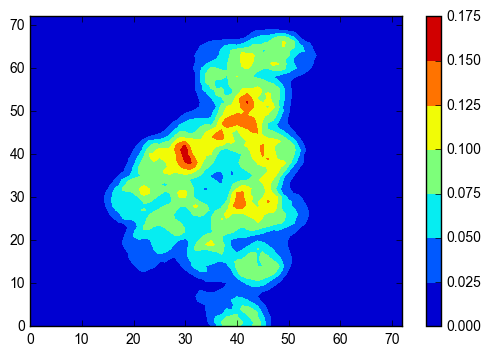

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.contourf(self.desolvationGrid[:,:,20])
plt.colorbar()

print np.sum(self.desolvationGrid)